In [1]:
import theano.tensor as tt
import pysal as ps
import matplotlib.pyplot as plt
import seaborn.apionly as sns
import numpy as np
import pandas as pd
import ops
import distributions as spdist
import scipy.sparse as spar
import scipy.sparse.linalg as spla
import pymc3 as mc
%matplotlib inline

In [2]:
df = ps.pdio.read_files(ps.examples.get_path('south.shp'))
df = df.query('STATE_NAME in ("Texas", "Oklahoma", "Arkansas", "Louisiana")')

In [3]:
df.head()

,FIPSNO,NAME,STATE_NAME,STATE_FIPS,CNTY_FIPS,FIPS,STFIPS,COFIPS,SOUTH,HR60,...,BLK90,GI59,GI69,GI79,GI89,FH60,FH70,FH80,FH90,geometry
288,40035,Craig,Oklahoma,40,035,40035,40,35,1,4.089227,...,3.424560,0.359287,0.416758,0.358676,0.380774,11.921235,8.7,9.077454,10.746190,<pysal.cg.shapes.Polygon object at 0x7f1e41e3a...
289,40105,Nowata,Oklahoma,40,105,40105,40,105,1,9.218289,...,3.642914,0.300158,0.410097,0.348434,0.378781,9.818679,7.9,6.892308,10.108052,<pysal.cg.shapes.Polygon object at 0x7f1e41e3a...
290,40115,Ottawa,Oklahoma,40,115,40115,40,115,1,5.889073,...,0.615163,0.318218,0.382949,0.361050,0.385546,12.741722,10.4,11.102620,12.518889,<pysal.cg.shapes.Polygon object at 0x7f1e41e3a...
291,40113,Osage,Oklahoma,40,113,40113,40,113,1,3.082519,...,10.109257,0.284325,0.376536,0.359410,0.381143,10.104046,7.6,8.170547,12.124602,<pysal.cg.shapes.Polygon object at 0x7f1e41e3a...
292,40071,Kay,Oklahoma,40,071,40071,40,71,1,1.959171,...,1.781255,0.262299,0.367160,0.355859,0.376317,9.218101,7.3,8.869334,9.808418,<pysal.cg.shapes.Polygon object at 0x7f1e41e3a...


In [4]:
df = df[df.HR90 > 0]

In [5]:
Y = np.log(df[['HR90']].values)
X = df[['GI89', 'FH90']].values
N,P = X.shape

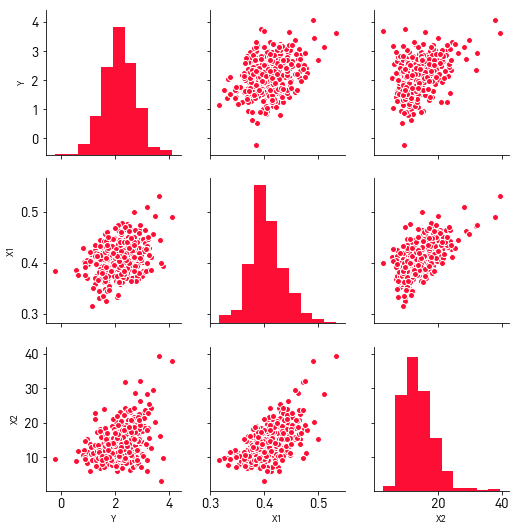

In [7]:
sns.pairplot(pd.DataFrame([Y.flatten(),*X.T], index = ['Y', 'X1', 'X2']).T)

In [8]:
W = ps.weights.Queen.from_dataframe(df)

In [9]:
W.transform = 'r'

In [10]:
Yknown = 4 + X.dot(np.asarray([[-2], [4]]))

In [11]:
Yknown_f = Yknown + np.linalg.solve((np.eye(W.n) - .45 * W.sparse.toarray()), 
                                    np.random.normal(0,1,size=(W.n,1)))

In [13]:
with mc.Model() as SE:
    a = mc.Normal('a', 0,sd=10, testval=0)
    beta = mc.Normal('beta', 0,sd=10, shape=P)
        
    rho = mc.Uniform('rho', lower=-.99, upper=.99, testval=0)
    
    mu = a + tt.dot(X, beta)
    
    outcome = spdist.SAR_Error('outcome', mu=mu, scale=1, rho=rho, method='Ord',
                               W=W, observed=Yknown_f.flatten(), shape=N)

In [19]:
with SE:
    start = mc.find_MAP()

         Current function value: 502.287465
         Iterations: 32
         Function evaluations: 118
         Gradient evaluations: 106


In [20]:
start

{'a': array(4.183933871231066),
 'beta': array([-2.40994873,  4.01318475]),
 'rho_interval_': array(3.7133686225644897)}

In [ ]:
with SE:
    trace = mc.sample(2000, step=mc.NUTS(), start=start)

/home/ljw/Dropbox/dev/pymc3/pymc3/sampling.py:163: UserWarning: Instantiated step methods cannot be automatically initialized. init argument ignored.
  warnings.warn('Instantiated step methods cannot be automatically initialized. init argument ignored.')
  0%|          | 0/2000 [00:00<?, ?it/s]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1e33db2320>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f1e33f78048>]], dtype=object)

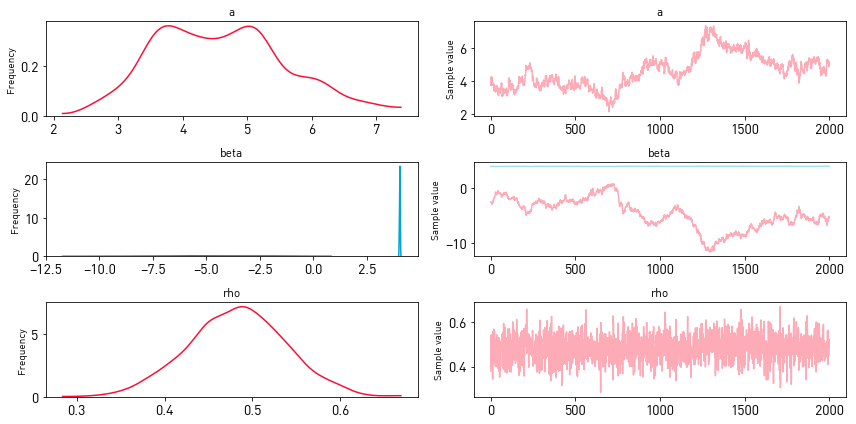

In [22]:
mc.traceplot(trace)

In [23]:
mc.summary(trace)


a:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  4.610            1.014            0.100            [2.624, 6.516]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  2.888          3.799          4.574          5.255          6.792


beta:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -4.716           2.791            0.277            [-9.896, 0.613]
  4.032            0.017            0.001            [3.998, 4.064]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -10.831        -6.402         -4.752         -2.517         0.219
  3.998          4.021          4.034      